# Method descriptions

* **centralized** finds global classifier using the centralized data
* Average local classifiers between neighbors
  * **avg-unweighted** all the edges have the same value
  * **avg-weighted** algorithm weights an edge as the *similarity* between the two nodes *times* the *number of instances* of the neighbor (normalized)
* **regularised** learns local classifiers keeping them similar to the neighbors' classifiers
* **local** learns independent local classifiers


In [2]:
# imports
from copy import deepcopy
import numpy as np

from sklearn.utils import shuffle

import sys
sys.path.append('../src/')

from evaluation import clf_variance, central_accuracy, central_loss, accuracies
from network import line_network, synthetic_graph, true_theta_graph
from optimization import average_FW, centralized_FW, regularized_local_FW, local_FW
from utils import generate_models, generate_samples

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# set graph of nodes with local personalized data
NB_ITER = 1000
N = 100
D = 20
NOISE_R = 0.05
random_state = 2017
MU = 0.1

V, theta_true, cluster_indexes = generate_models(nb_clust=1, nodes_per_clust=N, random_state=random_state)
_, X, Y, X_test, Y_test, _, _ = generate_samples(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes = synthetic_graph(X, Y, X_test, Y_test, V, theta_true)

# set callbacks for optimization analysis
callbacks = {
    'accuracy': [central_accuracy, []],
    'loss': [central_loss, []],
    'clf-variance': [clf_variance, []]
}

In [4]:
results = {}
hist_accuracies = {}

nodes_copy = deepcopy(nodes)
results["centralized"] = centralized_FW(nodes_copy, D, NB_ITER, callbacks=callbacks)
hist_accuracies["centralized"] = accuracies(nodes_copy)

nodes_copy = deepcopy(nodes)
results["regularized"] = regularized_local_FW(nodes_copy, D, NB_ITER, mu=MU, callbacks=callbacks)
hist_accuracies["regularized"] = accuracies(nodes_copy)

nodes_copy = deepcopy(nodes)
results["local"] = local_FW(nodes_copy, D, NB_ITER, callbacks=callbacks)
hist_accuracies["local"] = accuracies(nodes_copy)


# get results with true thetas
true_graph = true_theta_graph(nodes_copy, theta_true)
acc = central_accuracy(true_graph)
clf_var = clf_variance(true_graph)

print("done")

done


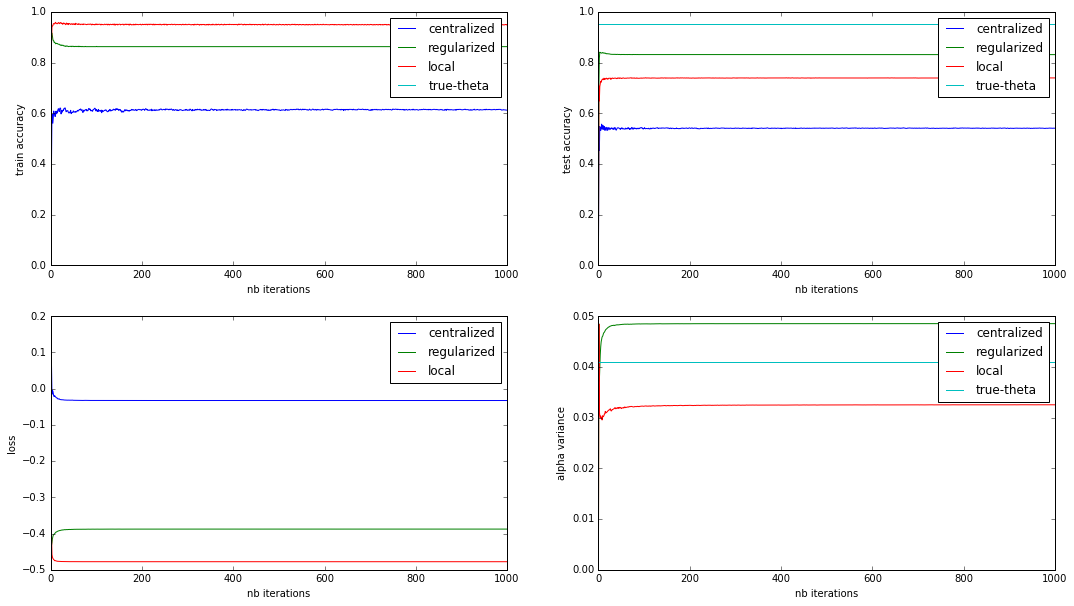

In [5]:
plt.figure(1, figsize=(18, 10))

plt.subplot(221)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][0] for r in r_list], label='{}'.format(k))
plt.plot(range(len(r_list)), [acc[0]]*len(r_list), label='true-theta')
plt.legend()

plt.subplot(222)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][1] for r in r_list], label='{}'.format(k))
plt.plot(range(len(r_list)), [acc[1]]*len(r_list), label='true-theta')
plt.legend()

plt.subplot(223)
plt.xlabel('nb iterations')
plt.ylabel('loss')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['loss'] for r in r_list], label='{}'.format(k))

plt.legend()

plt.subplot(224)
plt.xlabel('nb iterations')
plt.ylabel('alpha variance')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['clf-variance'] for r in r_list], label='{}'.format(k))
plt.plot(range(len(r_list)), [clf_var]*len(r_list), label='true-theta')
plt.legend()

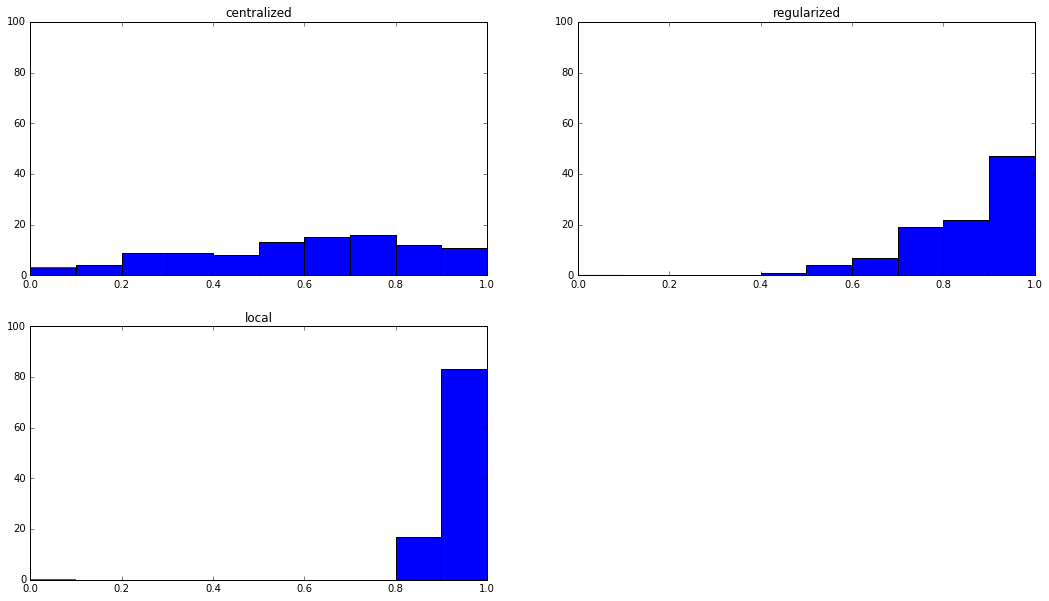

In [9]:
plt.suptitle("Histograms Train Accuracies")
plt.figure(2, figsize=(18, 10))

for i, (k, r_list) in enumerate(hist_accuracies.items()):

    plt.subplot(221 + i)
    plt.title(k)
    plt.ylim(0, N)
    plt.hist(r_list[0], 10, range=(0, 1))

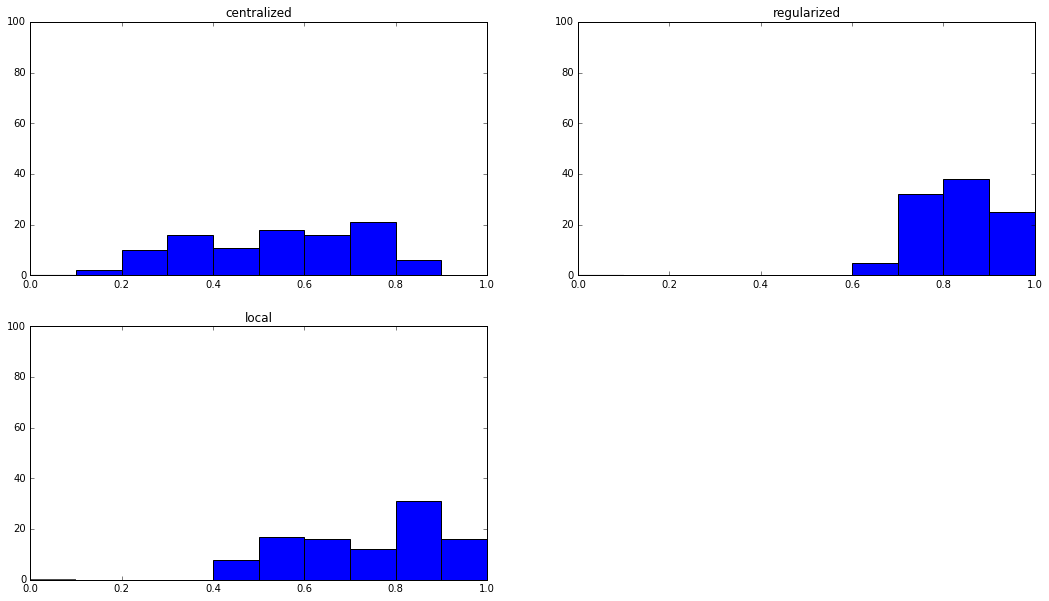

In [10]:
plt.suptitle("Histograms Test Accuracies")

plt.figure(2, figsize=(18, 10))

for i, (k, r_list) in enumerate(hist_accuracies.items()):

    plt.subplot(221 + i)
    plt.title(k)
    plt.ylim(0, N)
    plt.hist(r_list[1], 10, range=(0, 1))

### show first 20 iterations

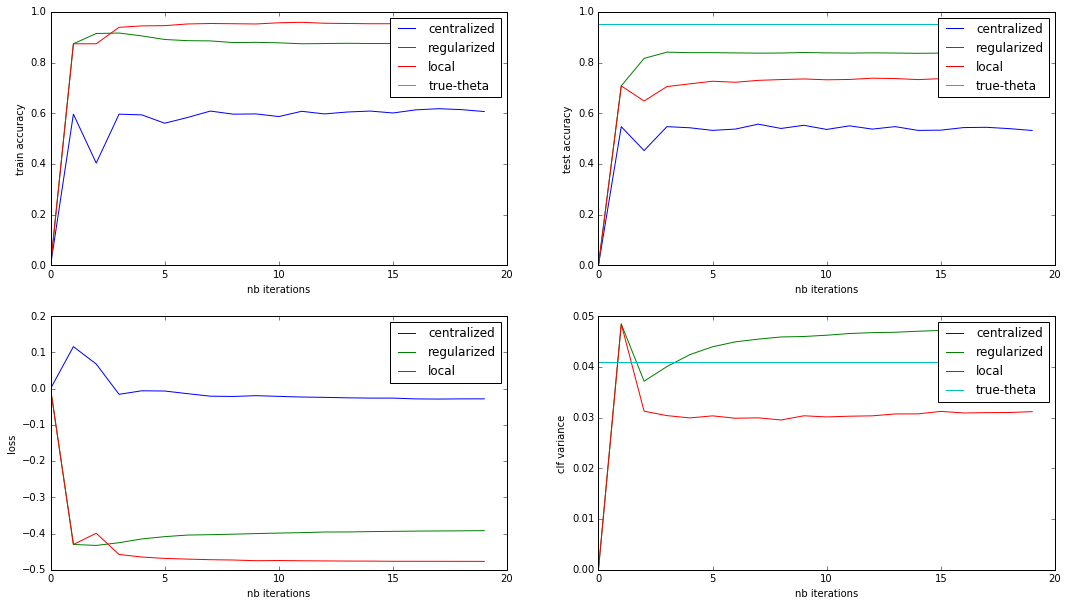

In [8]:
plt.figure(1, figsize=(18, 10))
max_iter = 20

plt.subplot(221)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')

for k, r_list in results.items():
    plt.plot(range(max_iter), [r['accuracy'][0] for r in r_list[:max_iter]], label='{}'.format(k))
plt.plot(range(max_iter), [acc[0]]*max_iter, label='true-theta')
plt.legend()

plt.subplot(222)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')

for k, r_list in results.items():
    plt.plot(range(max_iter), [r['accuracy'][1] for r in r_list[:max_iter]], label='{}'.format(k))
plt.plot(range(max_iter), [acc[1]]*max_iter, label='true-theta')
plt.legend()

plt.subplot(223)
plt.xlabel('nb iterations')
plt.ylabel('loss')

for k, r_list in results.items():
    plt.plot(range(max_iter), [r['loss'] for r in r_list[:max_iter]], label='{}'.format(k))

plt.legend()

plt.subplot(224)
plt.xlabel('nb iterations')
plt.ylabel('clf variance')

for k, r_list in results.items():
    plt.plot(range(max_iter), [r['clf-variance'] for r in r_list[:max_iter]], label='{}'.format(k))
plt.plot(range(max_iter), [clf_var]*max_iter, label='true-theta')
plt.legend()